# Can we predict anything about the antibiotic usage?

Lets start with '3 tobramycin_IV' because we have lots of pwCF with that!

In [1]:
import os
import sys

import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
from matplotlib.colors import ListedColormap
import pandas as pd
import seaborn as sns
import json

from itertools import cycle

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.inspection import permutation_importance

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error

from scipy.stats import linregress


# there is a FutureWarning in sklearn StandardScalar which is really annoying. This ignores it.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

try:
  import google.colab
  IN_COLAB = True
  !pip install adjustText
  from google.colab import drive
  drive.mount('/content/drive')
  datadir = '/content/drive/MyDrive/Projects/CF/Adelaide/CF_Data_Analysis'
except ImportError:
  IN_COLAB = False
  datadir = '..'

from adjustText import adjust_text

from socket import gethostname
hostname = gethostname()
if hostname.startswith('hpc-node'):
    IN_DEEPTHOUGHT = True
    sys.path.append('..')
else:
    IN_DEEPTHOUGHT = False

import cf_analysis_lib


In [2]:
def random_forest_regression(X, y):
  """
  Run a regressor for continuous data and return the mean squared error and the feature importances
  """

  # Split the data into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  # Initialize and train a RandomForestRegressor model
  model = RandomForestRegressor(random_state=42, n_estimators = 1000) # You can adjust hyperparameters
  model.fit(X_train, y_train)

  # Make predictions on the test set
  y_pred = model.predict(X_test)

  # Evaluate the model
  mse = mean_squared_error(y_test, y_pred)

  # Feature importance
  feature_importances = pd.DataFrame(model.feature_importances_, index=X.columns, columns=['importance'])
  feature_importances_sorted = feature_importances.sort_values(by='importance', ascending=False)
  return mse, feature_importances_sorted

def random_forest_classifier(X, y):
  """
  Run a classifier for categorical data and return the mean squared error and the feature importances
  """

  # Split the data into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  # Initialize and train a RandomForestRegressor model
  model = RandomForestClassifier(random_state=42, n_estimators = 1000) # You can adjust hyperparameters
  model.fit(X_train, y_train)

  # Make predictions on the test set
  y_pred = model.predict(X_test)

  # Evaluate the model
  mse = mean_squared_error(y_test, y_pred)

  # Feature importance
  feature_importances = pd.DataFrame(model.feature_importances_, index=X.columns, columns=['importance'])
  feature_importances_sorted = feature_importances.sort_values(by='importance', ascending=False)
  return mse, feature_importances_sorted



def plot_feature_importance(ax, feature_importances_sorted, title):

  # Create dotted lines and circles for each feature
  for feature in feature_importances_sorted.index[::-1]:
      importance = feature_importances_sorted.loc[feature, 'importance']
      ax.plot([importance], [feature], linestyle='dotted', marker='o', markersize=5, c='blue')
      ax.plot([0, importance], [feature, feature], linestyle='dotted', marker='None', markersize=5, c='lightblue')

  ax.set_xlabel("Importance")
  ax.set_ylabel("")
  ax.set_title(title)

def plot_feature_abundance(ax, feature_df, intcol, title):
    """
    Plot the top n important features.

    use something like this:
    top20 = list(feature_importances_sorted[:20].index)+[intcol]
    plot_feature_abundance(ax, merged_df[top20], intcol, f"Plot of normalised measures that are important to distinguish '{intcol}' usage")
    """
    
    # before we plot the data we scale the data to make the mean 0 and the variance 1.
    # you can compare the values before and after by looking at merged_df[top20].max() and  scaled_df.max()
    #scaler = StandardScaler()
    scaler = MinMaxScaler()
    scaled_df = pd.DataFrame(scaler.fit_transform(feature_df), columns=feature_df.columns)
    scaled_df[intcol] = feature_df[intcol].values
    
    melted_df = pd.melt(scaled_df, id_vars=[intcol], var_name='Feature', value_name='Value')

    sns.boxplot(data=melted_df, x='Value', y='Feature', hue=intcol, fill=False, legend=False, color='k', fliersize=0, ax=ax)
    sns.stripplot(data=melted_df, x='Value', y='Feature', hue=intcol, jitter=True, alpha=0.5, dodge=True, ax=ax)

    ax.set_title(title)
    ax.set_xlabel('Normalised Abundance')
    ax.set_ylabel('')


In [3]:
sequence_type = "MGI"
datadir = '..'
#sslevel = 'level2_norm_ss.tsv.gz'
sslevel = 'subsystems_norm_ss.tsv.gz'
ss_df = cf_analysis_lib.read_subsystems(os.path.join(datadir, sequence_type, "FunctionalAnalysis", "subsystems", sslevel), sequence_type)
ss_df = ss_df.T
print(f"The subsystems df has shape: {ss_df.shape}")

taxa = "genus"
genus_otu = cf_analysis_lib.read_taxonomy(datadir, sequence_type, taxa)
genus_otu = genus_otu.T
print(f"The taxonomy df has shape: {genus_otu.shape}")
metadata = cf_analysis_lib.read_metadata(datadir, sequence_type)
print(f"The metadata df has shape: {metadata.shape}")

The subsystems df has shape: (127, 769)
The taxonomy df has shape: (127, 3581)
The metadata df has shape: (127, 166)


In [4]:
df = ss_df.merge(genus_otu, left_index=True, right_index=True, how='inner')
print(df.shape)
df.head(5)

(127, 4350)


,"2,3-diacetamido-2,3-dideoxy-d-mannuronic acid",2-O-alpha-mannosyl-D-glycerate utilization,2-aminophenol Metabolism,2-ketoacid oxidoreductases disambiguation,2-oxoglutarate dehydrogenase,2-phosphoglycolate salvage,3-amino-5-hydroxybenzoic Acid Synthesis,4-hydroxybenzoyl-CoA reductase,5-methylaminomethyl-2-thiouridine,A Hypothetical Protein Related to Proline Metabolism,...,Oceaniferula,Persicirhabdus,Phragmitibacter,Prosthecobacter,Roseibacillus,Roseimicrobium,Sulfuriroseicoccus,Verrucomicrobium,Eremiobacter,Methylomirabilis
1068841_20180306_S,10.085904,2784.895948,516.160945,231.778018,122.573392,342.327431,783.041862,0.0,4136.703664,827.439614,...,1.347606,0.0,0.0,0.0,0.539042,0.0,0.0,0.539042,0.0,0.0
1447437_20171212_S,59.260325,1065.438272,543.947408,554.136026,428.171446,301.915763,679.310468,0.0,3913.676651,732.956657,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
1128691_20171206_S,0.000000,426.619709,912.767750,49.606943,213.640568,277.798880,423.312580,0.0,2093.412992,236.459761,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
1128691_20171218_S,0.000000,659.087578,864.137047,139.140711,235.318676,355.174973,538.254855,0.0,2050.494687,341.749115,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
1128691_20180116_S,14.478968,159.268644,593.637673,48.263225,358.354449,202.705547,348.701804,0.0,1570.967988,205.118708,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0


Mean Squared Error for all bacteria: 0.1475503846153846


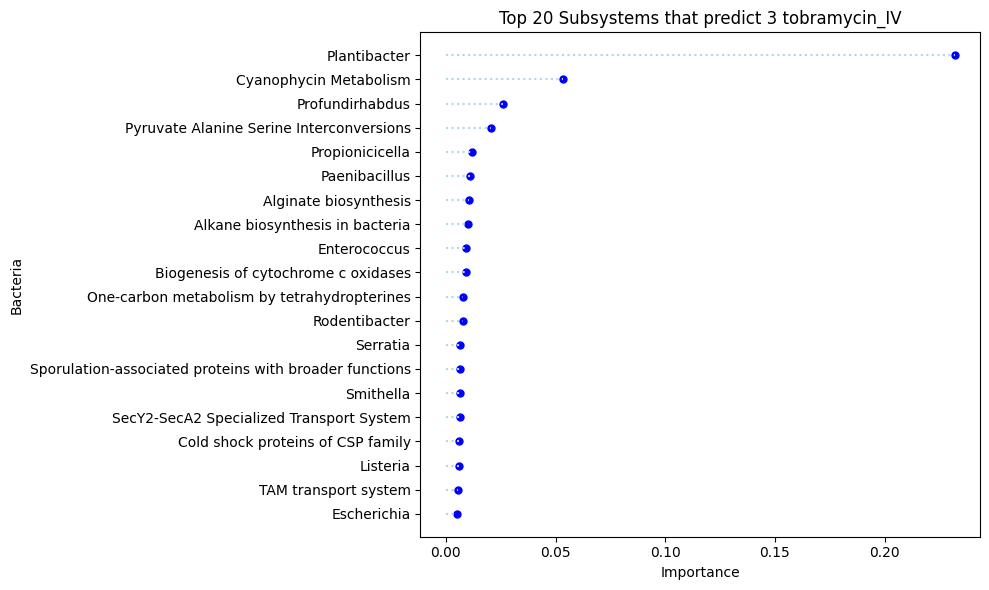

In [5]:
# this approach uses an inner join to ensure that we have the same 'interesting column' (intcol) 
# data in the same order as the data frame
intcol = '3 tobramycin_IV'
merged_df = df.join(metadata[[intcol]])

# this data set models all bacteria
X = merged_df.drop(intcol, axis=1)
y = merged_df[intcol]

y = y.fillna(y.mean())

if metadata[intcol].dtype == 'object':
  mse, feature_importances_sorted = random_forest_classifier(X, y)
  met = 'classification'
else:
  mse, feature_importances_sorted = random_forest_regression(X, y)
  met = 'regression'


print(f"Mean Squared Error for all bacteria: {mse}")

fig, axes = plt.subplots(figsize=(10,6), nrows=1, ncols=1)

plot_feature_importance(axes, feature_importances_sorted[:20], f"Top 20 Subsystems that predict {intcol}")


plt.tight_layout()
plt.show()

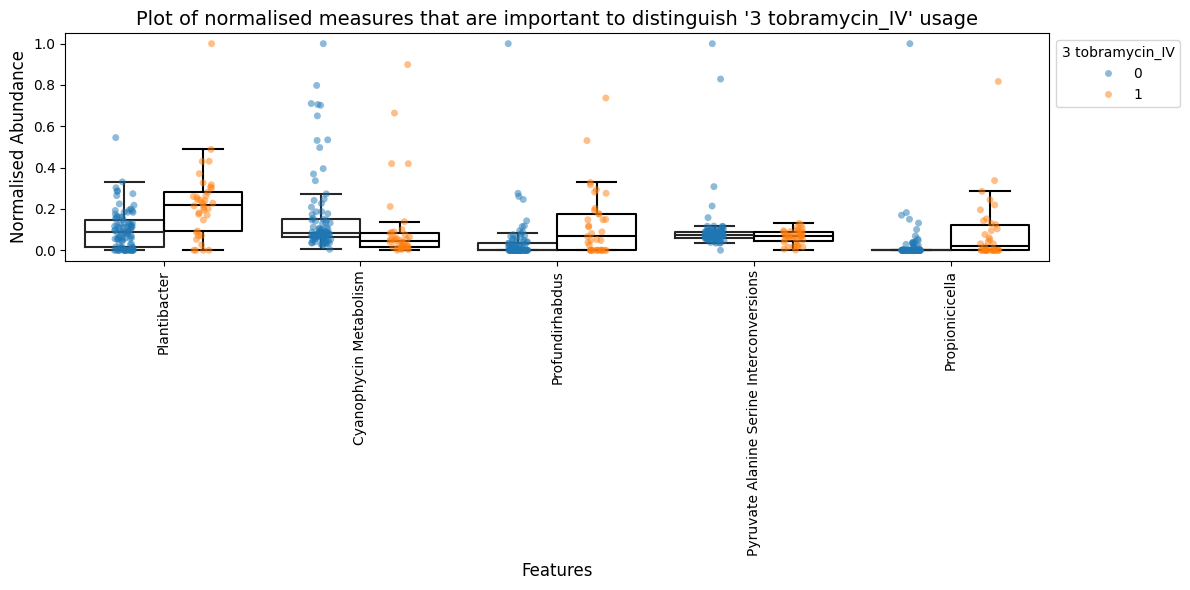

In [6]:
n=5
topN = list(feature_importances_sorted[:n].index)+[intcol]

# before we plot the data we scale the data to make the mean 0 and the variance 1.
# you can compare the values before and after by looking at merged_df[top20].max() and  scaled_df.max()
#scaler = StandardScaler()
scaler = MinMaxScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(merged_df[topN]), columns=topN)
scaled_df[intcol] = merged_df[intcol].values

melted_df = pd.melt(scaled_df, id_vars=[intcol], var_name='Feature', value_name='Value')

# Step 2: Plot the strip plot
fig = plt.figure(figsize=(12, 6))
#sns.violinplot(data=melted_df, x='Feature', y='Value', hue=intcol, split=False, alpha=0.5)
sns.boxplot(data=melted_df, x='Feature', y='Value', hue=intcol, fill=False, legend=False, color='k', fliersize=0)
#sns.boxplot(  data=melted_df, x='Feature', y='Value', hue=intcol)
sns.stripplot(data=melted_df, x='Feature', y='Value', hue=intcol, jitter=True, alpha=0.5, dodge=True)
# Note: Swarm plot doesn't work because too many 0's. Maybe with unnormalised numbers but then you can't see them
#sns.swarmplot(data=melted_df, x='Feature', y='Value', hue=intcol, alpha=0.5, dodge=True)


# Step 3: Customize the plot
plt.title(f"Plot of normalised measures that are important to distinguish '{intcol}' usage", fontsize=14)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Normalised Abundance', fontsize=12)
plt.xticks(rotation=90)
plt.legend(title=intcol, bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

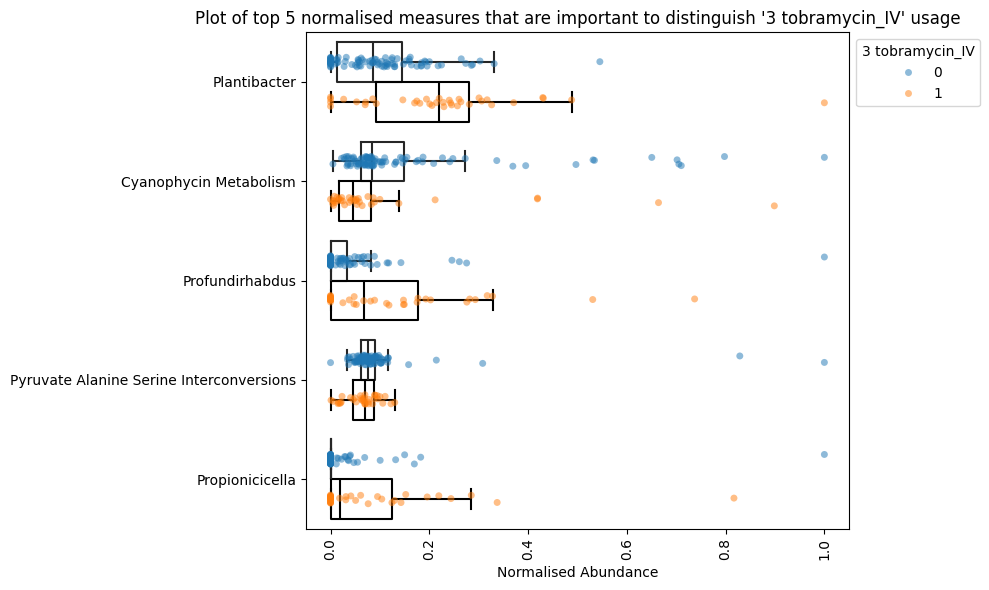

In [7]:
n = 5
topN = list(feature_importances_sorted[:n].index)+[intcol]
fig, axes = plt.subplots(figsize=(10,6), nrows=1, ncols=1)
title=f"Plot of top {n} normalised measures that are important to distinguish '{intcol}' usage"
plot_feature_abundance(axes, merged_df[topN], intcol, title)

plt.xticks(rotation=90)
plt.legend(title=intcol, bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

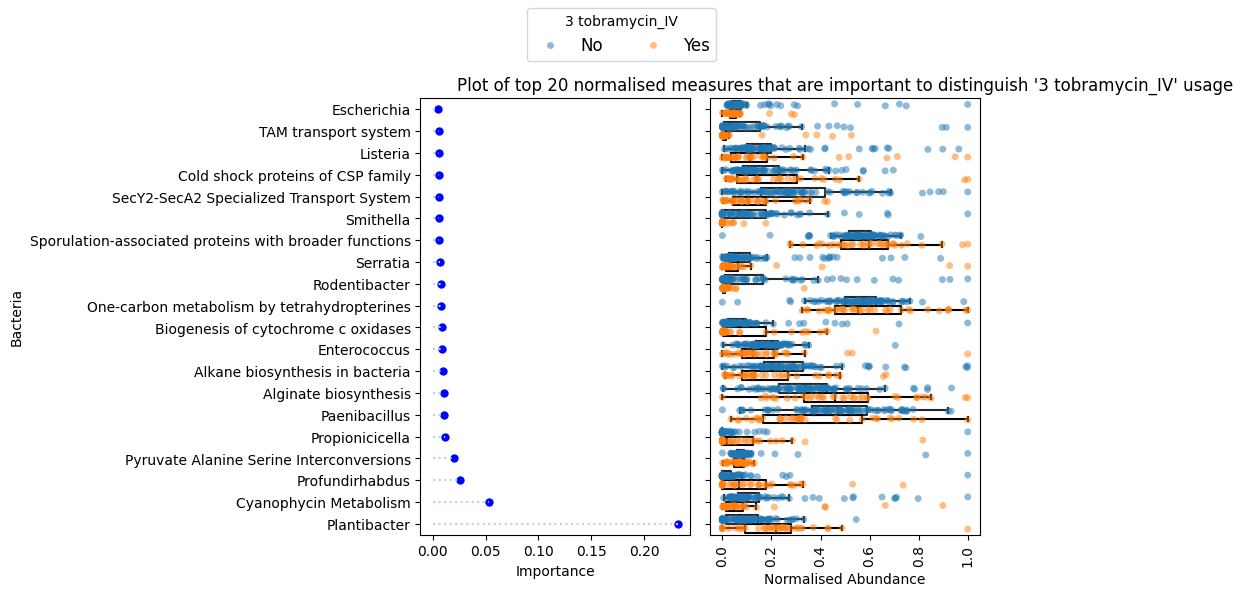

In [8]:
n = 20
topN = list(feature_importances_sorted[:n].index)+[intcol]

fig, axes = plt.subplots(figsize=(10,6), nrows=1, ncols=2, sharey=True)
title=f"Plot of top {n} normalised measures that are important to distinguish '{intcol}' usage"
plot_feature_importance(axes[0], feature_importances_sorted[:n], "")
plot_feature_abundance(axes[1], merged_df[topN], intcol, title)

custom_labels = {0: 'No', 1: 'Yes'}
handles, labels = axes[1].get_legend_handles_labels()  # Get one set of handles and labels
updated_labels = [custom_labels[int(label)] for label in labels]

for ax in axes.flat:
    if ax.get_legend() is not None:  # Check if legend exists
        ax.get_legend().remove()

plt.xticks(rotation=90)
fig.legend(handles, updated_labels, loc='upper center', ncol=2, fontsize=12, title=intcol)
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()

In [9]:
feature_importances_sorted

,importance
Plantibacter,0.231828
Cyanophycin Metabolism,0.053479
Profundirhabdus,0.025885
Pyruvate Alanine Serine Interconversions,0.020494
Propionicicella,0.011890
...,...
Sanguibacteroides,0.000000
Metaprevotella,0.000000
Palleniella,0.000000
Prevotellamassilia,0.000000


# All antibiotics.

At this stage, we are going to filter for those antibiotics where we have more than 6 data points, so not quite all!

In [22]:
antibiotics = ['1 Cephalexin_PO', '1 Flucloaxcillin_PO', '1 Itraconazole (Lozenoc)_PO', '1 Sulfamethoxazole_trimethoprim (Bactrim)_PO', '2 Amikacin_INH', '2 Amoxicillin & Potassium clavulanate (Aug Duo)_PO', '2 Amphotericin B (Ambisome)_INH', '2 Azithromycin_PO', '2 Ceftazidime_INH', '2 Ciprofloxacin_PO', '2 Clarithromycin_PO', '2 Clofazimine PO', '2 Colistin_IHN', '2 prednisolone_PO', '2 tobramycin_INH', '3 Azithromycin_IV', '3 Aztreonam_IV', '3 Cefopime_IV', '3 Ceftazidime_IV', '3 Imipenem', '3 Ivacaftor (Kalydeco)', '3 Meropenem_IV', '3 Methylpredinosolone_IV', '3 Omalizumab_SC', '3 piperacillin sodium, tazobactam sodium (Tazocin)_IV', '3 tobramycin_IV', '4 Amikacin_IV', '4 Cefoxitin_IV', '4 Colistin_IV']
antibiotic_counts = metadata[antibiotics].sum(axis=0)
antibiotic_counts[antibiotic_counts > 20].index

Index(['3 piperacillin sodium, tazobactam sodium (Tazocin)_IV', '3 tobramycin_IV'], dtype='object')

1 Itraconazole (Lozenoc)_PO	regression	0.06
2 Amoxicillin & Potassium clavulanate (Aug Duo)_PO	regression	0.04
2 Azithromycin_PO	regression	0.01
2 Ciprofloxacin_PO	regression	0.03
2 tobramycin_INH	regression	0.12
3 Ceftazidime_IV	regression	0.05
3 Methylpredinosolone_IV	regression	0.04
3 piperacillin sodium, tazobactam sodium (Tazocin)_IV	regression	0.11
3 tobramycin_IV	regression	0.15
4 Amikacin_IV	regression	0.04


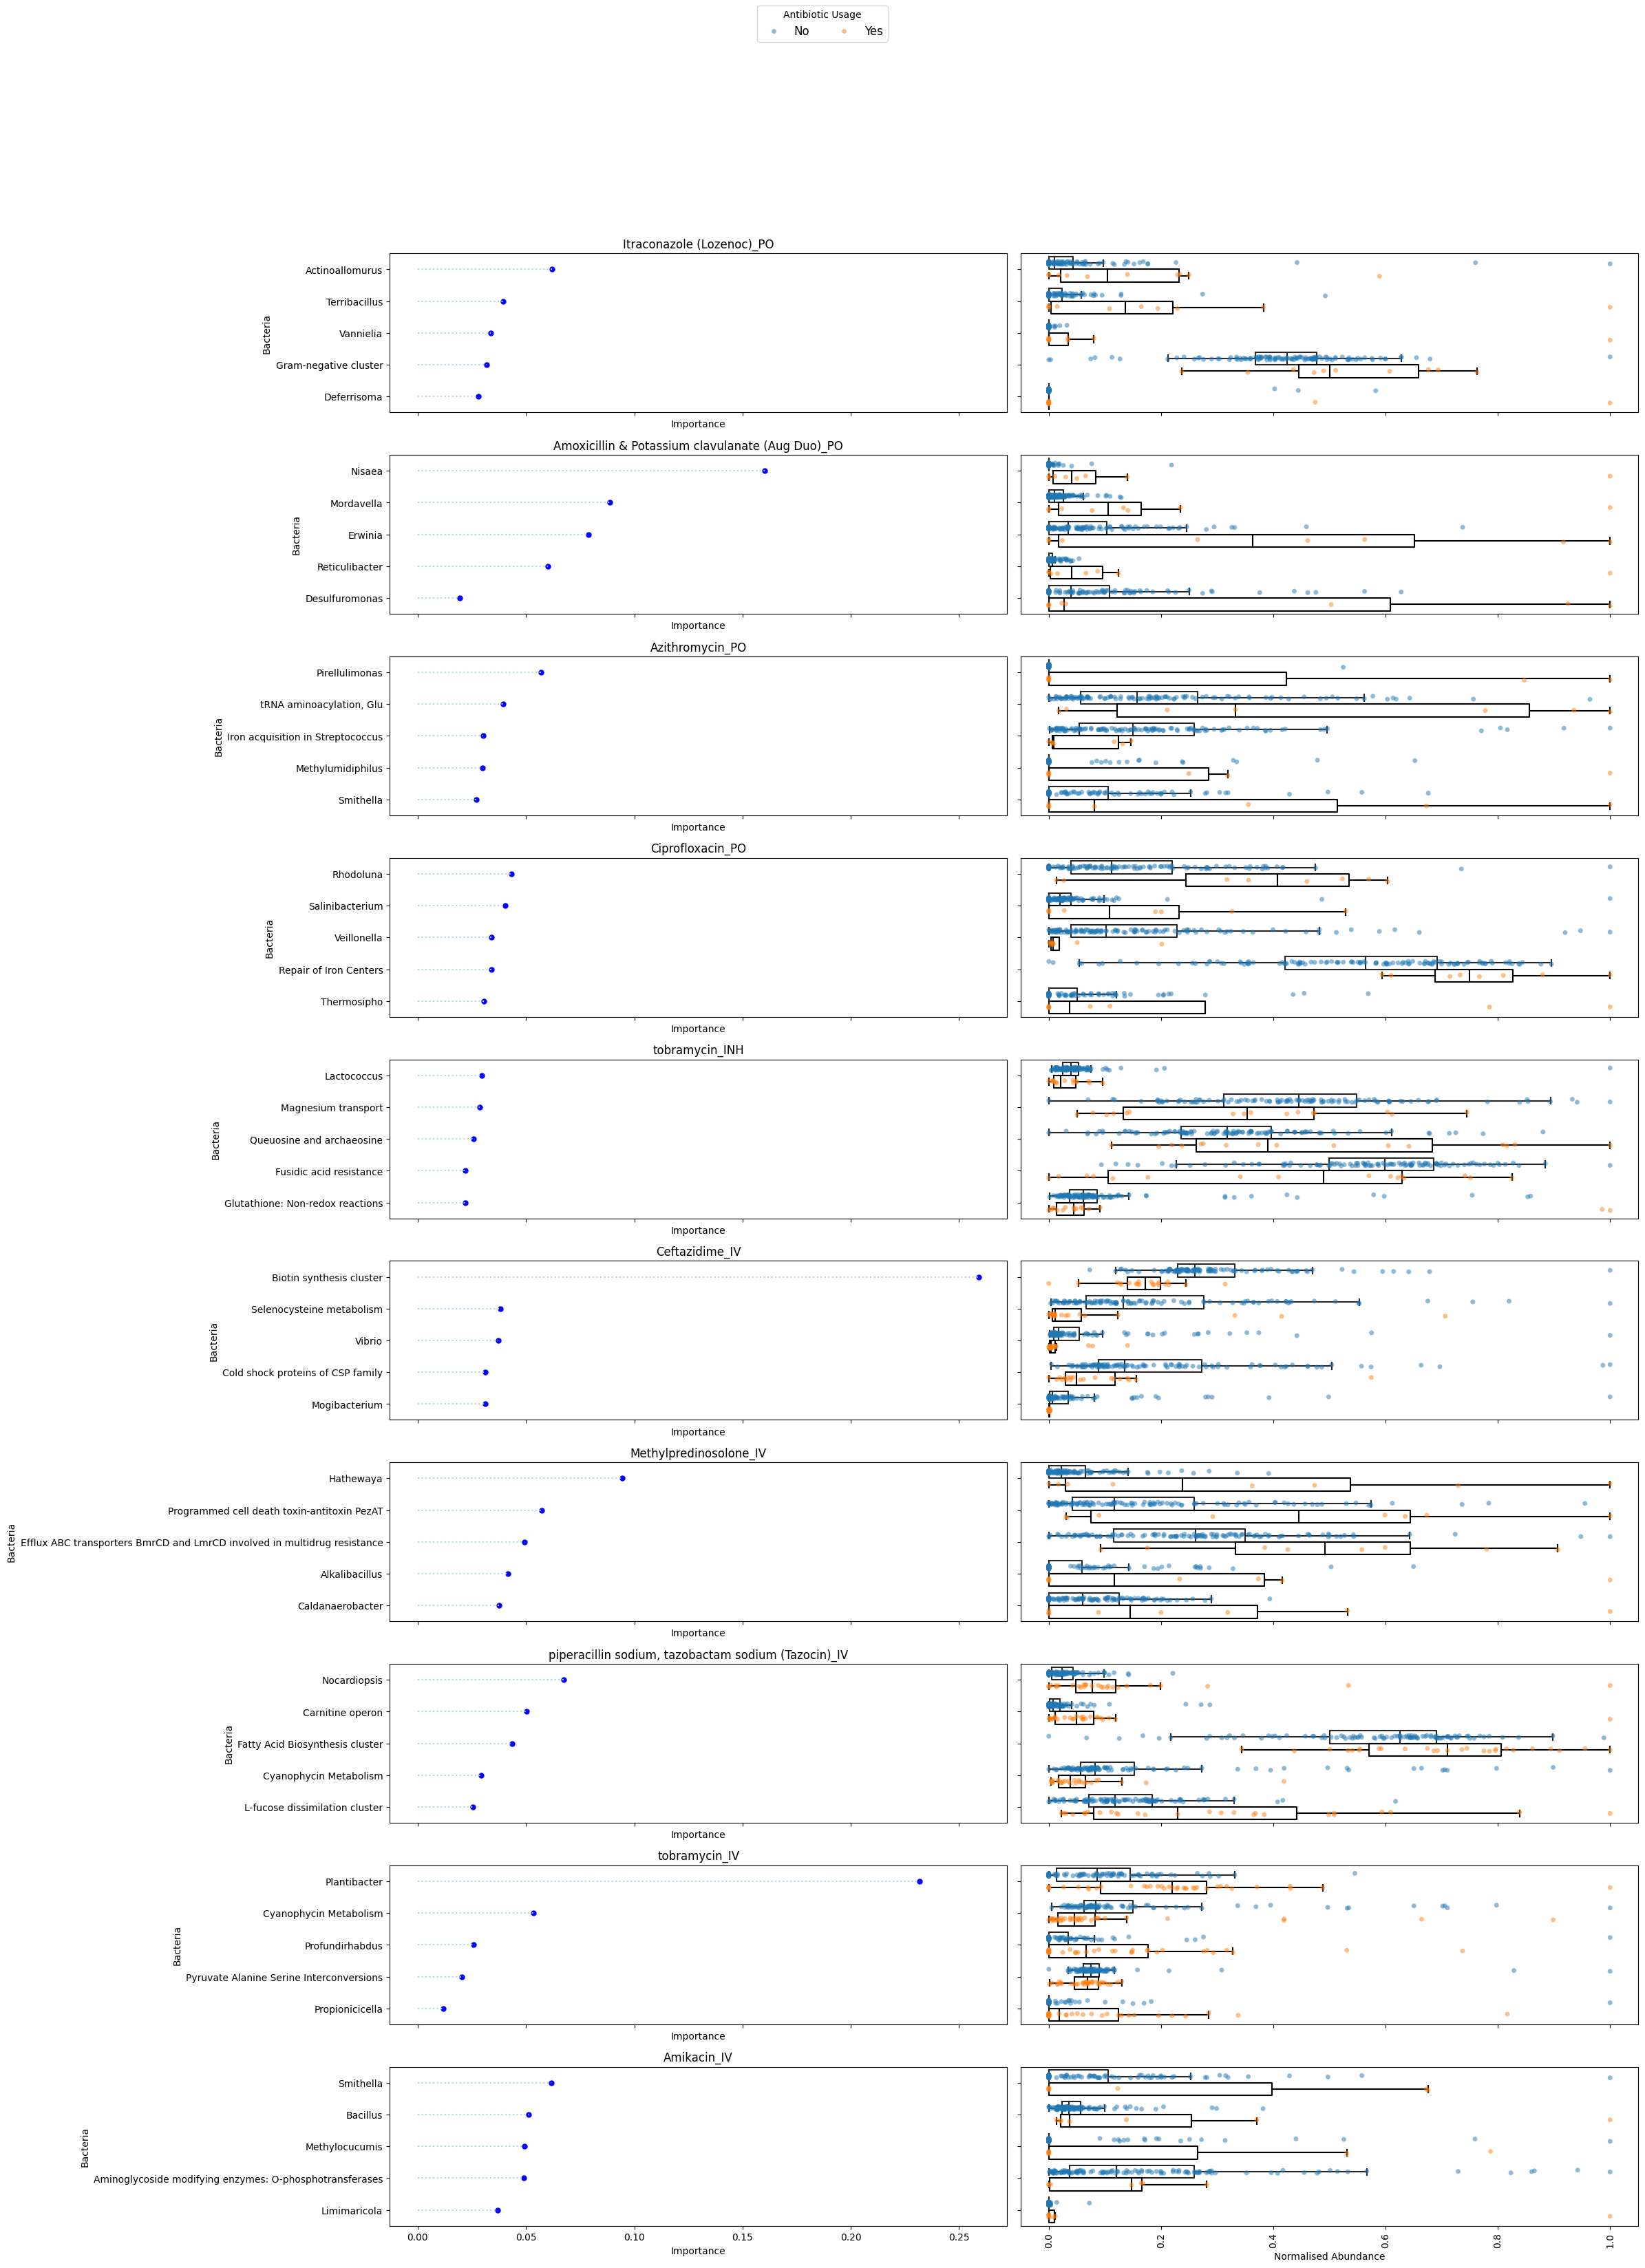

In [37]:
# this approach uses an inner join to ensure that we have the same 'interesting column' (intcol) 
# data in the same order as the data frame

minab = 6
numsamples = len(antibiotic_counts[antibiotic_counts > minab].index)
replace_index = re.compile(r'^\d+\s+')

fig, axes = plt.subplots(figsize=(24,33), nrows=numsamples, ncols=2, sharey='row', sharex='col')
for rownum, intcol in enumerate(antibiotic_counts[antibiotic_counts > minab].index):
    merged_df = df.join(metadata[[intcol]])
    X = merged_df.drop(intcol, axis=1)
    y = merged_df[intcol]
    
    y = y.fillna(y.mean())
    
    if metadata[intcol].dtype == 'object':
      mse, feature_importances_sorted = random_forest_classifier(X, y)
      met = 'classification'
    else:
      mse, feature_importances_sorted = random_forest_regression(X, y)
      met = 'regression'

    print(f"{intcol}\t{met}\t{mse:.2f}")
    
    n = 5
    topN = list(feature_importances_sorted[:n].index)+[intcol]
    

    #title=f"Plot of top {n} normalised measures that are important to distinguish '{intcol}' usage"
    
    plot_feature_importance(axes[rownum, 0], feature_importances_sorted[:n][::-1], replace_index.sub('', intcol))
    plot_feature_abundance(axes[rownum, 1], merged_df[topN][::-1], intcol, "")
    
custom_labels = {0: 'No', 1: 'Yes'}
handles, labels = axes[0,1].get_legend_handles_labels()  # Get one set of handles and labels
updated_labels = [custom_labels[int(label)] for label in labels]

for ax in axes.flat:
    if ax.get_legend() is not None:  # Check if legend exists
        ax.get_legend().remove()
    
plt.xticks(rotation=90)
fig.legend(handles, updated_labels, loc='upper center', ncol=2, fontsize=12, title='Antibiotic Usage')
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.savefig('img/ab_usage.png')
plt.show()